**submitted by**: Sourjya Mukherjee
**Sc_id**: 2014182 

Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Modules


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

Resizing images and masks and storing them in training and testing sets

In [ ]:
Img_width=256
Img_height=256
Img_channels=3

TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/Unet_with_resnet/stage1_train/'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/Unet_with_resnet/stage1_test/'


train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids),Img_height, Img_width, Img_channels), dtype=np.float32)
Y_train = np.zeros((len(train_ids), Img_height, Img_width, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:Img_channels]  
    img = resize(img, (Img_height, Img_width), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((Img_height, Img_width, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (Img_height, Img_width), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), Img_height, Img_width, Img_channels), dtype=np.float32)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:Img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (Img_height, Img_width), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


Resizing training images and masks


  0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


Resizing test images


100%|██████████| 65/65 [00:02<00:00, 26.84it/s]

Done!


Defining Simple Unet Model


In [ ]:
inputs=layers.Input((Img_height,Img_width,Img_channels))
s=layers.Lambda(lambda x : x/float(255))(inputs)

#Contractive_path

c1=layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=layers.Dropout(0.1)(c1)
c1=layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
c1=layers.Dropout(0.1)(c1)
p1=layers.MaxPooling2D((2,2))(c1)

c2=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=layers.Dropout(0.1)(c2)
c2=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
c2=layers.Dropout(0.1)(c2)
p2=layers.MaxPooling2D((2,2))(c2)

c3=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=layers.Dropout(0.1)(c3)
c3=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
c3=layers.Dropout(0.1)(c3)
p3=layers.MaxPooling2D((2,2))(c3)

c4=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=layers.Dropout(0.1)(c4)
c4=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
c4=layers.Dropout(0.1)(c4)
p4=layers.MaxPooling2D((2,2))(c4)

#bottle_neck
c5=layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=layers.Dropout(0.1)(c5)
c5=layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)


#Expansive_path

u6=layers.Conv2DTranspose(filters=128,kernel_size=(2,2),strides=(2,2),padding='same')(c5)
u6=layers.concatenate([c4,u6])
c6=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6=layers.Dropout(0.1)(c6)
c6=layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7=layers.Conv2DTranspose(filters=64,kernel_size=(2,2),strides=(2,2),padding='same')(c6)
u7=layers.concatenate([c3,u7])
c7=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7=layers.Dropout(0.1)(c7)
c7=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)


u8=layers.Conv2DTranspose(filters=32,kernel_size=(2,2),strides=(2,2),padding='same')(c7)
u8=layers.concatenate([c2,u8])
c8=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8=layers.Dropout(0.1)(c8)
c8=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9=layers.Conv2DTranspose(filters=16,kernel_size=(3,3),strides=(2,2),padding='same')(c8)
u9=layers.concatenate([c1,u9])
c9=layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9=layers.Dropout(0.1)(c9)
c9=layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

#%%
outputs =layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
Unet_model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
Unet_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#Unet_model.summary()
Unet_model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100)

Epoch 1/100
2/2 [==============================] - 19s 6s/step - loss: 0.6815 - accuracy: 0.5481 - val_loss: 0.7080 - val_accuracy: 0.7826
Epoch 2/100
2/2 [==============================] - 17s 6s/step - loss: 0.6292 - accuracy: 0.8210 - val_loss: 0.6573 - val_accuracy: 0.8070
Epoch 3/100
2/2 [==============================] - 17s 6s/step - loss: 0.5892 - accuracy: 0.8517 - val_loss: 0.6243 - val_accuracy: 0.8077
Epoch 4/100
2/2 [==============================] - 17s 6s/step - loss: 0.5072 - accuracy: 0.8520 - val_loss: 0.6587 - val_accuracy: 0.8077
Epoch 5/100
2/2 [==============================] - 17s 6s/step - loss: 0.6795 - accuracy: 0.8520 - val_loss: 0.5819 - val_accuracy: 0.8077
Epoch 6/100
2/2 [==============================] - 17s 6s/step - loss: 0.5181 - accuracy: 0.8520 - val_loss: 0.5903 - val_accuracy: 0.8078
Epoch 7/100
2/2 [==============================] - 17s 6s/step - loss: 0.5468 - accuracy: 0.8520 - val_loss: 0.5706 - val_accuracy: 0.8077
Epoch 8/100
2/2 [==========

Validating results

3/3 [==============================] - 10s 2s/step


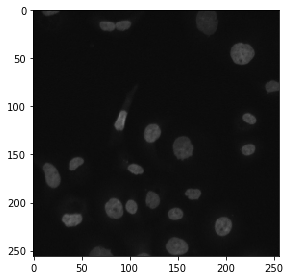

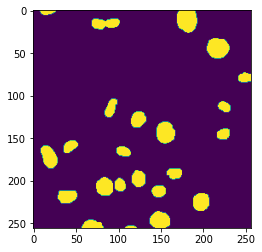

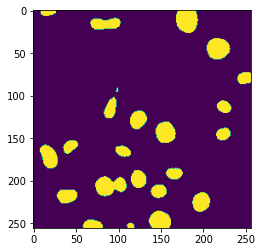

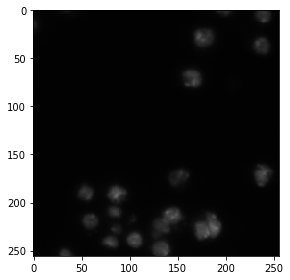

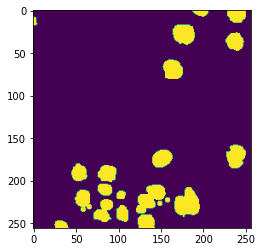

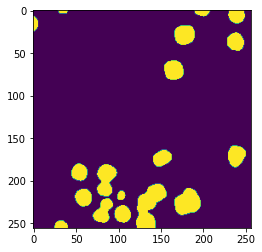

In [ ]:
idx = random.randint(0, len(X_train))


preds_train = Unet_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = Unet_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = Unet_model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)


ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(Y_train[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
plt.imshow(np.squeeze(preds_val_t[ix]))
plt.show()